In [140]:
# Importing dependencies
import pandas as pd
import numpy as np
# import OpenBlender
import datetime
import time
#from sqlalchemy import create_engine
#from config import db_password


In [141]:
sentiment_scores_df = pd.read_csv('Resources/reddit_comments_agg.csv')
sentiment_scores_df = sentiment_scores_df[1:]
sentiment_scores_df['normalised_date_dt64'] = [pd.to_datetime(x, format='%Y-%m-%d') for x in sentiment_scores_df['normalised_date']]
sentiment_scores_df.set_index(sentiment_scores_df['normalised_date_dt64'], inplace=True)
sentiment_scores_df2 = sentiment_scores_df.drop(columns=['normalised_date_dt64'])
sentiment_scores_df2.head()

,normalised_date,score,neg,neu,pos,compound,rolling
normalised_date_dt64,,,,,,,
2012-01-01,2012-01-01,3.333333,0.046400,0.893367,0.060233,0.086240,0.121112
2012-01-02,2012-01-02,2.121951,0.079707,0.818707,0.101561,0.042127,0.078388
2012-01-03,2012-01-03,2.590909,0.080000,0.817523,0.102477,0.029139,0.035952
2012-01-04,2012-01-04,2.725000,0.078175,0.833075,0.088750,0.049387,0.051089
2012-01-05,2012-01-05,3.585366,0.058146,0.846829,0.094976,0.170327,0.195525


In [142]:
# Read in files
df = pd.read_csv('Resources/bitcoin_data.zip')

# Display initial data
df.head(10)

# keep timestamp, high, low, weighted_price
df = df[['Timestamp', 'High', 'Low', 'Volume_(BTC)', 'Weighted_Price', 'Open', 'Close']].reset_index(drop=True)

# preprocessing notes-- consider omitting data prior to Jan 1st, 2012 due to higher volatility 
# earlier in bitcoin's lifecycle

# converting Timestamp column to str datatype
df['str_timestamp'] = [str(timestamp) for timestamp in df['Timestamp']]
df['int_timestamp'] = df['str_timestamp'].astype('int32', copy=True)

# filtering df to only include rows after 01/01/2012
df_cleaned_filtered = df.loc[df['int_timestamp'] >= 1325391360]
df_cleaned_filtered.head(2)

# context manager to suppress 1 time SettingWithCopyWarning; alternatively call .loc after timestamp conversion to avoid error
pd.reset_option('mode.chained_assignment')
with pd.option_context('mode.chained_assignment', None):
    df_cleaned_filtered['UTC_time'] = df_cleaned_filtered['int_timestamp'].apply(lambda x: datetime.datetime.utcfromtimestamp(x))

# dropping all null values, followed by evaluation of which time periods had the greatest data loss
final_df = df_cleaned_filtered.dropna().reset_index(drop=True)

# finding percentage of data loss (null values)
btotalLength = (len(df_cleaned_filtered))
bpartialLength = (len(final_df))
bValuesDropped = btotalLength - bpartialLength
bitstampDiff = (btotalLength - bpartialLength) / btotalLength * 100 
totalDays = round(btotalLength/1440,2)
daysDropped = round(bValuesDropped/1440,2)

print(f"Percentage of total Bitstamp data lost due to dropping rows with NaN values: {bitstampDiff:.2f}%")
print(f"Ratio of Bitstamp rows dropped: {bValuesDropped:,}/{btotalLength:,}")
print(f"Total dataset contains {totalDays} days worth of data. Due to data loss, we had to drop {daysDropped} days worth of data")

final_df.head(5)

# Rename columns to be sql friendly
final_df.rename({'Timestamp':'timestamp',
                  'High':'high',
                  'Low':'low',
                  'Volume_(BTC)':'volume',
                  'Weighted_Price':'weightedPrice',
                  'str_timestamp':'timestampSTR',
                  'int_timestamp':'timestampINT',
                  'UTC_time':'timeUTC'
                 }, axis='columns', inplace=True)


# Checking datatypes
print(final_df.dtypes)
final_df.head(2)

Percentage of total Bitstamp data lost due to dropping rows with NaN values: 27.14%
Ratio of Bitstamp rows dropped: 1,240,496/4,571,033
Total dataset contains 3174.33 days worth of data. Due to data loss, we had to drop 861.46 days worth of data
timestamp                 int64
high                    float64
low                     float64
volume                  float64
weightedPrice           float64
Open                    float64
Close                   float64
timestampSTR             object
timestampINT              int32
timeUTC          datetime64[ns]
dtype: object


,timestamp,high,low,volume,weightedPrice,Open,Close,timestampSTR,timestampINT,timeUTC
0,1325391360,4.58,4.58,1.502,4.58,4.58,4.58,1325391360,1325391360,2012-01-01 04:16:00
1,1325431680,4.84,4.84,10.000,4.84,4.84,4.84,1325431680,1325431680,2012-01-01 15:28:00


In [143]:
final_df['normalised_date'] = final_df['timeUTC'].dt.normalize()
final_df.head()

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampSTR,timestampINT,timeUTC,normalised_date
0,1325391360,4.58,4.58,1.502000,4.58,4.58,4.58,1325391360,1325391360,2012-01-01 04:16:00,2012-01-01
1,1325431680,4.84,4.84,10.000000,4.84,4.84,4.84,1325431680,1325431680,2012-01-01 15:28:00,2012-01-01
2,1325457900,5.00,5.00,10.100000,5.00,5.00,5.00,1325457900,1325457900,2012-01-01 22:45:00,2012-01-01
3,1325534640,5.00,5.00,19.048000,5.00,5.00,5.00,1325534640,1325534640,2012-01-02 20:04:00,2012-01-02
4,1325591100,5.32,5.32,2.419173,5.32,5.32,5.32,1325591100,1325591100,2012-01-03 11:45:00,2012-01-03


In [144]:
final_df['date_only'] = final_df['normalised_date']
# aggregated_df = final_df.groupby(final_df.normalised_date.dt.date, as_index=False).mean()

# use this line to keep dates as Series
# aggregated_df1 = final_df.groupby(final_df.normalised_date.dt.date, as_index=True).mean().reset_index()
# indices = aggregated_df1['normalised_date']

# dataframe with Time Series index
aggregated_df = final_df.groupby(final_df.normalised_date.dt.date, as_index=True).mean()

In [145]:
aggregated_df

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampINT
normalised_date,,,,,,,,
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,4.806667,4.806667,1.325427e+09
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,5.000000,5.000000,1.325535e+09
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,5.252500,5.252500,1.325605e+09
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,5.200000,5.223333,1.325682e+09
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,6.281429,6.286190,1.325771e+09
...,...,...,...,...,...,...,...,...
2020-09-10,1.599739e+09,10343.558552,10334.291588,7.119214,10339.359896,10338.759708,10338.760864,1.599739e+09
2020-09-11,1.599826e+09,10306.071361,10299.283936,3.660672,10303.242947,10302.414327,10302.451926,1.599826e+09
2020-09-12,1.599912e+09,10375.469839,10370.388713,1.754713,10373.259995,10372.770434,10372.583252,1.599912e+09


In [146]:
aggregated_df = pd.concat([aggregated_df,sentiment_scores_df], axis=1, join='inner')
aggregated_df.head()

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampINT,normalised_date,score,neg,neu,pos,compound,rolling,normalised_date_dt64
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,4.806667,4.806667,1.325427e+09,2012-01-01,3.333333,0.046400,0.893367,0.060233,0.086240,0.121112,2012-01-01
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,5.000000,5.000000,1.325535e+09,2012-01-02,2.121951,0.079707,0.818707,0.101561,0.042127,0.078388,2012-01-02
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,5.252500,5.252500,1.325605e+09,2012-01-03,2.590909,0.080000,0.817523,0.102477,0.029139,0.035952,2012-01-03
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,5.200000,5.223333,1.325682e+09,2012-01-04,2.725000,0.078175,0.833075,0.088750,0.049387,0.051089,2012-01-04
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,6.281429,6.286190,1.325771e+09,2012-01-05,3.585366,0.058146,0.846829,0.094976,0.170327,0.195525,2012-01-05


In [147]:
aggregated_df

,timestamp,high,low,volume,weightedPrice,Open,Close,timestampINT,normalised_date,score,neg,neu,pos,compound,rolling,normalised_date_dt64
2012-01-01,1.325427e+09,4.806667,4.806667,7.200667,4.806667,4.806667,4.806667,1.325427e+09,2012-01-01,3.333333,0.046400,0.893367,0.060233,0.086240,0.121112,2012-01-01
2012-01-02,1.325535e+09,5.000000,5.000000,19.048000,5.000000,5.000000,5.000000,1.325535e+09,2012-01-02,2.121951,0.079707,0.818707,0.101561,0.042127,0.078388,2012-01-02
2012-01-03,1.325605e+09,5.252500,5.252500,11.004660,5.252500,5.252500,5.252500,1.325605e+09,2012-01-03,2.590909,0.080000,0.817523,0.102477,0.029139,0.035952,2012-01-03
2012-01-04,1.325682e+09,5.223333,5.200000,11.914807,5.208159,5.200000,5.223333,1.325682e+09,2012-01-04,2.725000,0.078175,0.833075,0.088750,0.049387,0.051089,2012-01-04
2012-01-05,1.325771e+09,6.286190,6.281429,4.514373,6.284127,6.281429,6.286190,1.325771e+09,2012-01-05,3.585366,0.058146,0.846829,0.094976,0.170327,0.195525,2012-01-05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-09-10,1.599739e+09,10343.558552,10334.291588,7.119214,10339.359896,10338.759708,10338.760864,1.599739e+09,2020-09-10,1.900000,0.065841,0.835543,0.098622,0.170521,0.165506,2020-09-10
2020-09-11,1.599826e+09,10306.071361,10299.283936,3.660672,10303.242947,10302.414327,10302.451926,1.599826e+09,2020-09-11,1.515260,0.068309,0.821795,0.109898,0.147518,0.141176,2020-09-11
2020-09-12,1.599912e+09,10375.469839,10370.388713,1.754713,10373.259995,10372.770434,10372.583252,1.599912e+09,2020-09-12,3.245926,0.065944,0.828458,0.105636,0.152564,0.165354,2020-09-12
2020-09-13,1.599999e+09,10396.386007,10390.076996,3.056612,10393.662602,10393.230099,10392.960134,1.599999e+09,2020-09-13,3.279534,0.064995,0.831902,0.103080,0.144426,0.145943,2020-09-13


In [148]:
date_price_df = aggregated_df[['weightedPrice']]
daily_deltas = date_price_df.pct_change(periods=1)
# monthly_deltas = date_price_df.pct_change(freq='M')
#aggregated_df['pct_change'] = aggregated_df.pct_change('weightedPrice', periods=1, index='normalised_date')

In [149]:
date_price_df['daily_pct_change'] = daily_deltas
date_price_df

C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,weightedPrice,daily_pct_change
2012-01-01,4.806667,NaN
2012-01-02,5.000000,0.040222
2012-01-03,5.252500,0.050500
2012-01-04,5.208159,-0.008442
2012-01-05,6.284127,0.206593
...,...,...
2020-09-10,10339.359896,0.014840
2020-09-11,10303.242947,-0.003493
2020-09-12,10373.259995,0.006796
2020-09-13,10393.662602,0.001967


In [150]:
len(date_price_df)

3177

In [151]:
# Creating the time-series index
n=len(date_price_df)
index = pd.date_range('2012-01-01', periods = n,freq='D')
index

DatetimeIndex(['2012-01-01', '2012-01-02', '2012-01-03', '2012-01-04',
               '2012-01-05', '2012-01-06', '2012-01-07', '2012-01-08',
               '2012-01-09', '2012-01-10',
               ...
               '2020-09-02', '2020-09-03', '2020-09-04', '2020-09-05',
               '2020-09-06', '2020-09-07', '2020-09-08', '2020-09-09',
               '2020-09-10', '2020-09-11'],
              dtype='datetime64[ns]', length=3177, freq='D')

In [152]:
date_price_df = date_price_df.set_index(index)

In [153]:
# finding monthly % change
monthly = date_price_df.resample('BM').apply(lambda x: x[-1])
monthly.drop(columns=['daily_pct_change'], inplace=True)
monthly['monthly_pct_change'] = monthly.pct_change()
monthly

,weightedPrice,monthly_pct_change
2012-01-31,5.614045,NaN
2012-02-29,4.952722,-0.117798
2012-03-30,4.836740,-0.023418
2012-04-30,4.950282,0.023475
2012-05-31,5.136571,0.037632
...,...,...
2020-05-29,9585.242823,0.067412
2020-06-30,9093.863232,-0.051264
2020-07-31,11255.501070,0.237703
2020-08-31,11039.063579,-0.019229


In [154]:
three_months= date_price_df.resample('3M').apply(lambda x: x[-1])
three_months.drop(columns=['daily_pct_change'], inplace=True)
#three_months['quarterly_pct_change'] = three_months['daily_pct_change']

three_months['quarterly_pct_change'] = three_months.pct_change()
three_months

,weightedPrice,quarterly_pct_change
2012-01-31,5.614045,NaN
2012-04-30,4.950282,-0.118233
2012-07-31,9.199746,0.858429
2012-10-31,10.826328,0.176807
2013-01-31,20.230478,0.868637
2013-04-30,141.614016,6.000033
2013-07-31,98.923727,-0.301455
2013-10-31,200.809802,1.029946
2014-01-31,801.904549,2.993354
2014-04-30,445.661972,-0.444246


In [155]:
yearly = date_price_df.resample('Y').apply(lambda x: x[-1])
yearly.drop(columns=['daily_pct_change'], inplace=True)
# yearly['yearly_pct_change'] = yearly['daily_pct_change']
yearly['yearly_pct_change'] = yearly.pct_change()
yearly

,weightedPrice,yearly_pct_change
2012-12-31,13.196513,NaN
2013-12-31,728.728912,54.221323
2014-12-31,314.514811,-0.568406
2015-12-31,429.069676,0.364227
2016-12-31,1019.992995,1.377220
2017-12-31,14962.379078,13.669100
2018-12-31,3829.104391,-0.744085
2019-12-31,7218.040867,0.885047
2020-12-31,10332.429402,0.431473


In [156]:
date_price_merged = pd.merge(left=date_price_df, right=monthly, how='left')
date_price_merged['dt_index'] = index
date_price_merged

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index
0,4.806667,NaN,NaN,2012-01-01
1,5.000000,0.040222,NaN,2012-01-02
2,5.252500,0.050500,NaN,2012-01-03
3,5.208159,-0.008442,NaN,2012-01-04
4,6.284127,0.206593,NaN,2012-01-05
...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07
3173,10303.242947,-0.003493,NaN,2020-09-08
3174,10373.259995,0.006796,NaN,2020-09-09
3175,10393.662602,0.001967,NaN,2020-09-10


In [157]:
date_price_merged = pd.merge(left=date_price_merged, right=yearly, how='left')
date_price_merged

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index,yearly_pct_change
0,4.806667,NaN,NaN,2012-01-01,NaN
1,5.000000,0.040222,NaN,2012-01-02,NaN
2,5.252500,0.050500,NaN,2012-01-03,NaN
3,5.208159,-0.008442,NaN,2012-01-04,NaN
4,6.284127,0.206593,NaN,2012-01-05,NaN
...,...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07,NaN
3173,10303.242947,-0.003493,NaN,2020-09-08,NaN
3174,10373.259995,0.006796,NaN,2020-09-09,NaN
3175,10393.662602,0.001967,NaN,2020-09-10,NaN


In [158]:
date_price_merged.iloc[59]

weightedPrice                     4.95272
daily_pct_change              -0.00779485
monthly_pct_change              -0.117798
dt_index              2012-02-29 00:00:00
yearly_pct_change                     NaN
Name: 59, dtype: object

In [159]:
log_diffs = aggregated_df[['Open','Close']]
# date_price_merged['daily_log_diff'] = np.log(log_diffs['Close']) - np.log(log_diffs['Open'])
date_price_merged['daily_log_diff'] = [np.log(x)- np.log(y) for x,y in zip(log_diffs['Close'], log_diffs['Open'])]

In [160]:
# log diff can be interpreted as an approximation of "percentage change"
date_price_merged

# for visualization purposes, might be interesting to plot normal weightedPrice vs Time, daily_log_diff vs Time, and a log_diff histogram
# when presenting, can filter by month/year to better observe changes within each year

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index,yearly_pct_change,daily_log_diff
0,4.806667,NaN,NaN,2012-01-01,NaN,0.000000e+00
1,5.000000,0.040222,NaN,2012-01-02,NaN,0.000000e+00
2,5.252500,0.050500,NaN,2012-01-03,NaN,0.000000e+00
3,5.208159,-0.008442,NaN,2012-01-04,NaN,4.477142e-03
4,6.284127,0.206593,NaN,2012-01-05,NaN,7.578054e-04
...,...,...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07,NaN,1.118112e-07
3173,10303.242947,-0.003493,NaN,2020-09-08,NaN,3.649569e-06
3174,10373.259995,0.006796,NaN,2020-09-09,NaN,-1.804566e-05
3175,10393.662602,0.001967,NaN,2020-09-10,NaN,-2.597539e-05


In [161]:
# creating our targets (1 for net pct increase, 0 for no change/decrease)
# our target predicts whether or not there is positive performance
date_price_merged['target'] = [1 if x > 0 else 0 for x in date_price_merged['daily_log_diff']]
date_price_merged

,weightedPrice,daily_pct_change,monthly_pct_change,dt_index,yearly_pct_change,daily_log_diff,target
0,4.806667,NaN,NaN,2012-01-01,NaN,0.000000e+00,0
1,5.000000,0.040222,NaN,2012-01-02,NaN,0.000000e+00,0
2,5.252500,0.050500,NaN,2012-01-03,NaN,0.000000e+00,0
3,5.208159,-0.008442,NaN,2012-01-04,NaN,4.477142e-03,1
4,6.284127,0.206593,NaN,2012-01-05,NaN,7.578054e-04,1
...,...,...,...,...,...,...,...
3172,10339.359896,0.014840,NaN,2020-09-07,NaN,1.118112e-07,1
3173,10303.242947,-0.003493,NaN,2020-09-08,NaN,3.649569e-06,1
3174,10373.259995,0.006796,NaN,2020-09-09,NaN,-1.804566e-05,0
3175,10393.662602,0.001967,NaN,2020-09-10,NaN,-2.597539e-05,0


In [162]:
# can use OpenBlender (NLP) to supplement findings with news articles, vectorize input parameters as 1 and 0

In [163]:
# applying ML model and observing results
# importing dependencies
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

In [164]:
# temporarily dropping monthly/annual log calculations since they contain NaN values
# also dropping very 1st value (cannot calculate deltas from nothing)
date_price_merged2 = date_price_merged.drop(columns=['monthly_pct_change','yearly_pct_change'])
date_price_merged2 = date_price_merged2.iloc[1:]
date_price_merged2

,weightedPrice,daily_pct_change,dt_index,daily_log_diff,target
1,5.000000,0.040222,2012-01-02,0.000000e+00,0
2,5.252500,0.050500,2012-01-03,0.000000e+00,0
3,5.208159,-0.008442,2012-01-04,4.477142e-03,1
4,6.284127,0.206593,2012-01-05,7.578054e-04,1
5,6.438999,0.024645,2012-01-06,1.552795e-03,1
...,...,...,...,...,...
3172,10339.359896,0.014840,2020-09-07,1.118112e-07,1
3173,10303.242947,-0.003493,2020-09-08,3.649569e-06,1
3174,10373.259995,0.006796,2020-09-09,-1.804566e-05,0
3175,10393.662602,0.001967,2020-09-10,-2.597539e-05,0


In [165]:
date_price_merged3 = date_price_merged2.set_index(date_price_merged2['dt_index'])
date_price_merged3

,weightedPrice,daily_pct_change,dt_index,daily_log_diff,target
dt_index,,,,,
2012-01-02,5.000000,0.040222,2012-01-02,0.000000e+00,0
2012-01-03,5.252500,0.050500,2012-01-03,0.000000e+00,0
2012-01-04,5.208159,-0.008442,2012-01-04,4.477142e-03,1
2012-01-05,6.284127,0.206593,2012-01-05,7.578054e-04,1
2012-01-06,6.438999,0.024645,2012-01-06,1.552795e-03,1
...,...,...,...,...,...
2020-09-07,10339.359896,0.014840,2020-09-07,1.118112e-07,1
2020-09-08,10303.242947,-0.003493,2020-09-08,3.649569e-06,1
2020-09-09,10373.259995,0.006796,2020-09-09,-1.804566e-05,0


In [166]:
date_price_merged2.columns

Index(['weightedPrice', 'daily_pct_change', 'dt_index', 'daily_log_diff',
       'target'],
      dtype='object')

In [275]:
date_price_merged2 = pd.concat([date_price_merged3, sentiment_scores_df2], axis=1, join='inner')
date_price_merged2.drop(columns=['normalised_date','daily_log_diff','rolling','dt_index'], inplace=True)
date_price_merged2

,weightedPrice,daily_pct_change,target,score,neg,neu,pos,compound
2012-01-02,5.000000,0.040222,0,2.121951,0.079707,0.818707,0.101561,0.042127
2012-01-03,5.252500,0.050500,0,2.590909,0.080000,0.817523,0.102477,0.029139
2012-01-04,5.208159,-0.008442,1,2.725000,0.078175,0.833075,0.088750,0.049387
2012-01-05,6.284127,0.206593,1,3.585366,0.058146,0.846829,0.094976,0.170327
2012-01-06,6.438999,0.024645,1,2.063830,0.063638,0.825553,0.110809,0.210717
...,...,...,...,...,...,...,...,...
2020-09-07,10339.359896,0.014840,1,1.257449,0.068073,0.825540,0.106390,0.156567
2020-09-08,10303.242947,-0.003493,1,1.080357,0.067413,0.823720,0.108853,0.185623
2020-09-09,10373.259995,0.006796,0,1.156284,0.065800,0.831169,0.103004,0.156549
2020-09-10,10393.662602,0.001967,0,1.900000,0.065841,0.835543,0.098622,0.170521


In [259]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# creating training and testing datasets
df = date_price_merged2

X = df.loc[:,df.columns != 'target'].select_dtypes(include=[np.number]).values
y = df.loc[:,['target']].values


scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)
# div = int(round(len(X) * 0.2)) # allocating 20% of dataset for testing

# shuffling dataset to create randomized test and train splits
# x = np.random.rand(len(df),5)
# np.random.shuffle(x)
# training, test = x[:div,:], x[div:,:]

# X_train = X[:div]
# y_train = y[:div]
# X_test = X[div:]
# y_test= y[div:]

X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.2)

In [260]:
print(len(X_train))
print(len(X_test))

2540
636


In [170]:
# creating random forest classifier
cls = RandomForestRegressor(n_estimators=1000)
cls.fit(X_train, np.ravel(y_train, order='C'))
y_pred = cls.predict(X_test)

df_residuals = pd.DataFrame({'y_test':y_test[:, 0], 'y_pred':y_pred})
df_residuals

,y_test,y_pred
0,0,0.567
1,1,0.606
2,0,0.578
3,1,0.695
4,0,0.502
...,...,...
631,1,0.307
632,0,0.360
633,0,0.306
634,1,0.670


In [171]:
# calculating base model's accuracy based on only 'weightedPrice' and 'daily_pct_change'
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in df_residuals['y_pred']]
print(confusion_matrix(predictions, df_residuals['y_test']))

print('Accuracy score: ')
print(accuracy_score(predictions, df_residuals['y_test']))

print('Precision score: ')
print(precision_score(predictions, df_residuals['y_test']))

[[182 145]
 [134 175]]
Accuracy score: 
0.5613207547169812
Precision score: 
0.546875


In [172]:
# based on the confusion matrix, there were 1329 total daily price increase events
# our model predicted 1329 + 3 = 1,332 total price increase events, where 3 were False Positives
# there were a total of 1,209 + 3 = 1,212 total price DECREASE events, our model detected 1,209 and missed 3 events

# precision: high precision indicates low false positive rate, also known as ratio of correctly predicted positive observations to all observations in total class
# accuracy: high accuracy indicates the ratio of correct predictions made out of total observations

In [173]:
# comparing multiple models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [174]:
# calculating optimal hyperparameters for random forest classifier based on RandomSearchCV

from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in range(20,2021,200)] #trees per forest
max_features = ['auto', 'sqrt', 'log2', None]
max_depth = [int(x) for x in range(10,111,10)] #tree depth
max_depth.append(None)

min_samples_split = [2, 4, 6, 10]
min_samples_leaf = [1, 2, 4, 6, 8]
bootstrap = [True, False]

# input grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [20, 220, 420, 620, 820, 1020, 1220, 1420, 1620, 1820, 2020], 'max_features': ['auto', 'sqrt', 'log2', None], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 4, 6, 10], 'min_samples_leaf': [1, 2, 4, 6, 8], 'bootstrap': [True, False]}


In [175]:
# after generating random input grid, create base model
rf_random = RandomizedSearchCV(estimator=RandomForestClassifier(), 
                    param_distributions=random_grid,
                    n_iter=100,
                    cv=3,
                    refit=True,
                    verbose=3,
                    error_score=0,
                    n_jobs=-1)

In [176]:
# training model 
rf_random.fit(X_train, np.ravel(y_train, order='C'))

# viewing the best parameters from cross validation
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  6.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  7.3min finished


{'n_estimators': 820,
 'min_samples_split': 10,
 'min_samples_leaf': 6,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [177]:
# creating our random forest classifier with tuned hyperparameters
best_random = rf_random.best_estimator_
best_random

RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=6,
                       min_samples_split=10, n_estimators=820)

In [178]:
# GridSearchCV tuning for XGBoost

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

params = {
    'min_child_weght': [1,5,10],
    'gamma': [0.5, 1, 1.5, 2, 5],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'max_depth': [3,4,5]
}

xgb = XGBClassifier(learning_rate=0.02, n_estimators=600, objective='binary:logistic', silent=False)
skf = StratifiedKFold(n_splits=3, shuffle=True)

# brute force grid search
grid = GridSearchCV(estimator=xgb, 
                    param_grid=params,
                    cv=10,
                    verbose=3,
                    scoring='roc_auc',
                    n_jobs=-1)

In [179]:
# fiting tuned xgboost
fitted_model = grid.fit(X_train, np.ravel(y_train, order='C'))
best_xgb = fitted_model

Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   37.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 10.0min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 13.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 22.1min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 27.7min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 29.5min finished
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be

[17:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_weght, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:18:44] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [180]:
def compare_models(X_train, y_train, X_test, y_test):
  models = [
            ('LogReg', LogisticRegression()),
            ('RF', RandomForestClassifier()),
            ('KNN', KNeighborsClassifier()),
            ('SVC', SVC()),
            ('GNB', GaussianNB()),
            ('XGB', XGBClassifier()),
            ('oRF', best_random),
            ('oXGB', best_xgb)
  ]

  dfs = []
  results = []
  names = []
  scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
  target_names = ['increase', 'decrease']


# performing K-Fold cross validation 
  for name, model in models:
    kfold = model_selection.KFold(n_splits=5, shuffle=True)
    cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
    clf = model.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(name)
    print(classification_report(y_test, y_pred, target_names=target_names))

    results.append(cv_results)
    names.append(name)
    this_df = pd.DataFrame(cv_results)
    this_df['model'] = name
    dfs.append(this_df)
  
  final = pd.concat(dfs, ignore_index=True)
  return final

In [181]:
final = compare_models(X_train, np.ravel(y_train, order='C'), X_test, y_test)
final

C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Patri\anaconda3\envs\PythonData\lib\s

LogReg
              precision    recall  f1-score   support

    increase       0.00      0.00      0.00       316
    decrease       0.50      1.00      0.67       320

    accuracy                           0.50       636
   macro avg       0.25      0.50      0.33       636
weighted avg       0.25      0.50      0.34       636

RF
              precision    recall  f1-score   support

    increase       0.57      0.58      0.57       316
    decrease       0.58      0.57      0.57       320

    accuracy                           0.57       636
   macro avg       0.57      0.57      0.57       636
weighted avg       0.57      0.57      0.57       636

KNN
              precision    recall  f1-score   support

    increase       0.56      0.57      0.56       316
    decrease       0.57      0.56      0.56       320

    accuracy                           0.56       636
   macro avg       0.56      0.56      0.56       636
weighted avg       0.56      0.56      0.56       636

SVC
 

C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[17:18:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[17:18:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGB
              precision    recall  f1-score   support

    increase       0.53      0.54      0.54       316
    decrease       0.54      0.53      0.53       320

    accuracy                           0.53       636
   macro avg       0.53      0.53      0.53       636
weighted avg       0.53      0.53      0.53       636

oRF
              precision    recall  f1-score   support

    increase       0.58      0.58      0.58       316
    decrease       0.59      0.59      0.59       320

    accuracy                           0.58       636
   macro avg       0.58      0.58      0.58       636
weighted avg       0.58      0.58      0.58       636

Fitting 10 folds for each of

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 11.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 14.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 18.2min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 23.6min finished
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be

[17:42:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_weght, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[17:42:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   31.1s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  8.1min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 13.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 17.5min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 22.9min finished
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be

[18:05:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_weght, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:05:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 13.2min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 17.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 28.0min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 29.7min finished
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be

[18:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_weght, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:35:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    5.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed: 10.7min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 13.6min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 16.3min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 19.4min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 23.1min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 24.4min finished
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be

[18:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_weght, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[18:59:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   28.4s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  5.5min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  7.2min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 12.4min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 20.3min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 21.6min finished
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be

[19:21:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_weght, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:21:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Fitting 10 folds for each of 405 candidates, totalling 4050 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 112 tasks      | elapsed:   32.9s
[Parallel(n_jobs=-1)]: Done 272 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1136 tasks      | elapsed:  6.6min
[Parallel(n_jobs=-1)]: Done 1552 tasks      | elapsed:  9.1min
[Parallel(n_jobs=-1)]: Done 2032 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 15.8min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 20.2min
[Parallel(n_jobs=-1)]: Done 3856 tasks      | elapsed: 25.0min
[Parallel(n_jobs=-1)]: Done 4050 out of 4050 | elapsed: 26.5min finished
C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\xgboost\sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be

[19:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { min_child_weght, silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[19:47:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
oXGB
              precision    recall  f1-score   support

    increase       0.58      0.59      0.58       316
    decrease       0.58      0.57      0.58       320

    accuracy                           0.58       636
   macro avg       0.58      0.58      0.58       636
weighted avg

,fit_time,score_time,test_accuracy,test_precision_weighted,test_recall_weighted,test_f1_weighted,test_roc_auc,model
0,0.012955,0.005979,0.509843,0.541768,0.509843,0.492145,0.528148,LogReg
1,0.003987,0.004985,0.498031,0.248035,0.498031,0.331148,0.553298,LogReg
2,0.010964,0.003986,0.519685,0.515188,0.519685,0.510596,0.516109,LogReg
3,0.002990,0.004982,0.517717,0.268030,0.517717,0.353202,0.565981,LogReg
4,0.002991,0.004982,0.478346,0.228815,0.478346,0.309556,0.578803,LogReg
5,0.586042,0.048870,0.505906,0.506085,0.505906,0.505758,0.534714,RF
6,0.521223,0.040863,0.541339,0.541697,0.541339,0.541045,0.576335,RF
7,0.540192,0.038906,0.566929,0.567479,0.566929,0.567063,0.586172,RF
8,0.570056,0.052824,0.547244,0.552169,0.547244,0.547244,0.562988,RF
9,0.747499,0.055812,0.559055,0.560930,0.559055,0.559438,0.571122,RF


In [182]:
# dynamically generate columns for visualizing

bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics

## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')

## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

Text(0.5, 1.0, 'Model Comparisons')

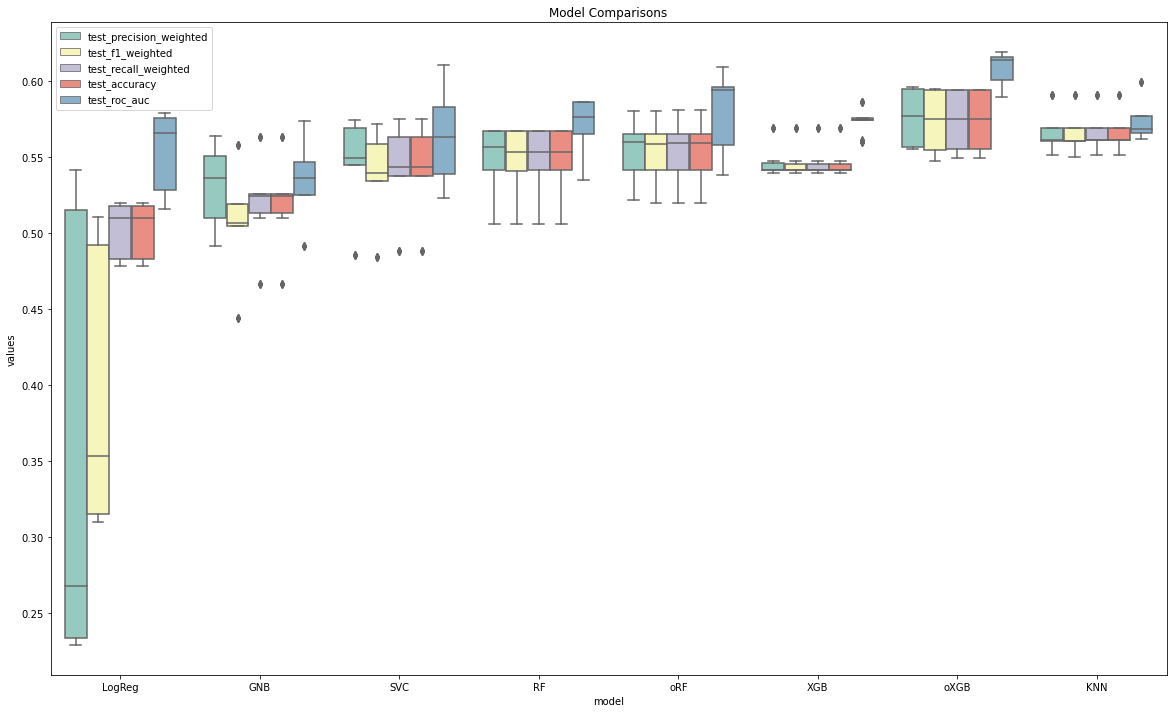

In [193]:
# visualizing model classifier performance
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20, 12))
fig = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(loc=0)
plt.title('Model Comparisons')

Text(0.5, 1.0, 'Model Training & Prediction Time Comparison')

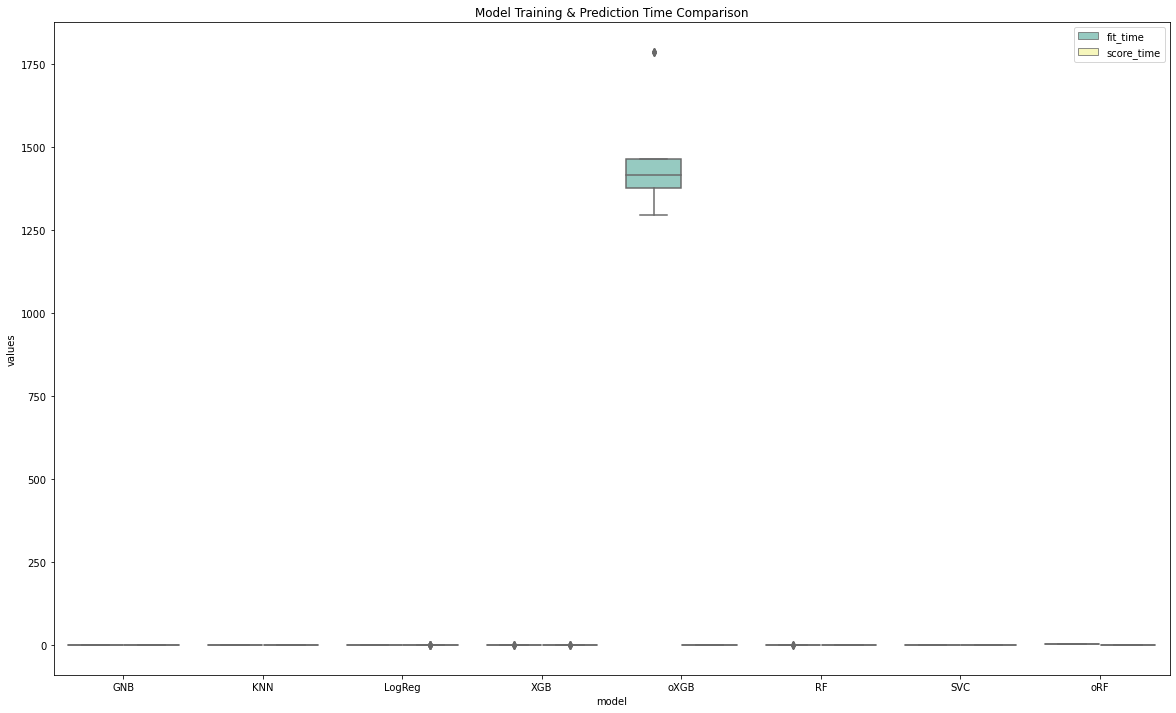

In [184]:
# visualizing training and scoring times
plt.figure(figsize=(20, 12))
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(loc=0)
plt.title('Model Training & Prediction Time Comparison')

# notes for further analysis -- consider Neural Network which generally takes large amounts of data/time to train, but might yield better results

In [185]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_precision_weighted           test_roc_auc           test_accuracy  \
                           std      mean          std      mean           std   
model                                                                           
GNB                   0.026927  0.532571     0.027557  0.536711      0.030908   
KNN                   0.013479  0.568557     0.014594  0.574770      0.013487   
LogReg                0.138893  0.351514     0.024331  0.552253      0.016930   
RF                    0.023254  0.547290     0.019237  0.570033      0.022966   
SVC                   0.032079  0.545288     0.029967  0.561716      0.029809   
XGB                   0.011318  0.547103     0.008741  0.574772      0.011393   
oRF                   0.019835  0.553453     0.026477  0.579896      0.020530   
oXGB                  0.017111  0.577259     0.010664  0.608965      0.018438   

                 test_f1_weighted           test_recall_weighted            
            mean              std      mean                  std      mean  
model                                                                       
GNB     0.522441         0.036474  0.510462             0.030908  0.522441  
KNN     0.568438         0.013743  0.568201             0.013487  0.568438  
LogReg  0.504003         0.084684  0.393379             0.016930  0.504003  
RF      0.546391         0.023111  0.546393             0.022966  0.546391  
SVC     0.541010         0.029707  0.537371             0.029809  0.541010  
XGB     0.546785         0.011403  0.546817             0.011393  0.546785  
oRF     0.552822         0.020392  0.552788             0.020530  0.552822  
oXGB    0.575131         0.019016  0.574852             0.018438  0.575131

In [189]:
oxgb_y_pred = best_xgb.predict(X_test)
error = np.mean(oxgb_y_pred != y_test)
print(f'Our oXGB model correctly predicted {round((1-error)*100,2)}% results')

Our oXGB model correctly predicted 49.997033345199945% results


In [192]:
cls=RandomForestClassifier()
cls.fit(X_train, np.ravel(y_train,order='C'))
y_pred = cls.predict(X_test)

error = np.mean(y_pred != y_test)
print(f'Our oXGB model correctly predicted {round((1-error)*100,2)}% results')

Our oXGB model correctly predicted 49.99% results


Our oXGB model correctly predicted 50.0% results


In [187]:
pred = fitted_model.predict(X_test)

In [ ]:
### aditional modeling

In [357]:
date_price_merged2 = pd.concat([date_price_merged3, sentiment_scores_df2], axis=1, join='inner')
date_price_merged2.drop(columns=['normalised_date','daily_log_diff','rolling','dt_index'], inplace=True)

# creating training and testing datasets
df = date_price_merged2

X = df.loc[:,df.columns != 'target'].select_dtypes(include=[np.number]).values
y = df.loc[:,['target']].values


scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(scaled, y, test_size=0.2)

In [358]:
scaled.shape

(3176, 7)

In [284]:
## multilayer perceptron
import tensorflow as tf 

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Dense(100, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(50, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

model.compile(optimizer="adam", loss="mean_squared_error")

In [286]:
model.fit(X_train, y_train, epochs=100)

Epoch 1/100
80/80 [==============================] - 0s 622us/step - loss: 0.2599
Epoch 2/100
80/80 [==============================] - 0s 610us/step - loss: 0.2465
Epoch 3/100
80/80 [==============================] - 0s 523us/step - loss: 0.2449
Epoch 4/100
80/80 [==============================] - 0s 536us/step - loss: 0.2453
Epoch 5/100
80/80 [==============================] - 0s 511us/step - loss: 0.2437
Epoch 6/100
80/80 [==============================] - 0s 560us/step - loss: 0.2436
Epoch 7/100
80/80 [==============================] - 0s 563us/step - loss: 0.2425
Epoch 8/100
80/80 [==============================] - 0s 536us/step - loss: 0.2421
Epoch 9/100
80/80 [==============================] - 0s 536us/step - loss: 0.2451
Epoch 10/100
80/80 [==============================] - 0s 586us/step - loss: 0.2444
Epoch 11/100
80/80 [==============================] - 0s 598us/step - loss: 0.2423
Epoch 12/100
80/80 [==============================] - 0s 523us/step - loss: 0.2431
Epoch 13/100


80/80 [==============================] - 0s 536us/step - loss: 0.2306
Epoch 100/100
80/80 [==============================] - 0s 550us/step - loss: 0.2324


In [291]:
model.evaluate(X_test, y_test)

20/20 [==============================] - 0s 847us/step - loss: 0.2379


0.23790627717971802

In [304]:
x_shape = np.reshape(X_train, X_train.shape + (1,))
y_shape = np.reshape(y_train, y_train.shape + (1,))
x_shaped = np.reshape(X_test, X_test.shape + (1,))

model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(7,1), return_sequences=True))
model.add(tf.keras.layers.LSTM(20))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

model.compile(optimizer="adam", loss="mean_squared_error")

model.fit(x_shape, y_train, epochs=50)

model.evaluate(x_shaped, y_test)

Epoch 1/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 2/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 3/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 4/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 5/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 6/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 7/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 8/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 9/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 10/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 11/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 12/50
80/80 [==============================] - 0s 4ms/step - loss: 0.5087
Epoch 13/50
80/80 [==============================

0.4858490526676178

In [305]:
model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_47 (LSTM)               (None, 7, 50)             10400     
_________________________________________________________________
lstm_48 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 21        
Total params: 16,101
Trainable params: 16,101
Non-trainable params: 0
_________________________________________________________________


In [306]:
y_pred = model.predict(x_shaped)

In [307]:
error = np.mean(y_pred != y_test)
print(f'Our ANN correctly predicted {round((1-error)*100,2)}% results')

Our ANN correctly predicted 51.42% results


In [470]:
#x_shape = np.reshape(X_train, X_train.shape + (1,))
#y_shape = np.reshape(y_train, y_train.shape + (1,))
#x_shaped = np.reshape(X_test, X_test.shape + (1,))


model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(128, input_shape=(6,1), return_sequences=False))
model.add(tf.keras.layers.Dense(105, activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dense(80, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(35, activation=tf.nn.relu))
model.add(tf.keras.layers.Dense(1, activation=tf.nn.relu))

model.compile(optimizer="adam", loss="mean_squared_error", metrics=['acc'])

model.fit(x_shape, y_shape, epochs=850)

model.evaluate(x_shaped, y_shaped)

Epoch 1/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 2/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 3/850
20/20 [==============================] - 0s 3ms/step - loss: 0.4236 - acc: 0.5764
Epoch 4/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 5/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 6/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 7/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 8/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 9/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 10/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 11/850
20/20 [==============================] - 0s 4m

Epoch 87/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 88/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 89/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 90/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 91/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 92/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 93/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 94/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 95/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 96/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 97/850
20/20 [==============================

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 173/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 174/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 175/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 176/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 177/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 178/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 179/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 180/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 181/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 182/850
20/20 [==============================] -

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 258/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 259/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 260/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 261/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 262/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 263/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 264/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 265/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 266/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 267/850
20/20 [==============================] -

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 343/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 344/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 345/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 346/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 347/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 348/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 349/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 350/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 351/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 352/850
20/20 [==============================] -

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 428/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 429/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 430/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 431/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 432/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 433/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 434/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 435/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 436/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 437/850
20/20 [==============================] -

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 513/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 514/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 515/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 516/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 517/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 518/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 519/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 520/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 521/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 522/850
20/20 [==============================] -

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 598/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 599/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 600/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 601/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 602/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 603/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 604/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 605/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 606/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 607/850
20/20 [==============================] -

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 683/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 684/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 685/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 686/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 687/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 688/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 689/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 690/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 691/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 692/850
20/20 [==============================] -

20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 768/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 769/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 770/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 771/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 772/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 773/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 774/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 775/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 776/850
20/20 [==============================] - 0s 4ms/step - loss: 0.4236 - acc: 0.5764
Epoch 777/850
20/20 [==============================] -

[0.5242030620574951, 0.4757969379425049]

In [415]:
y_pred = model.predict(x_shaped)
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in y_pred]
error = np.mean(predictions != y_test)
print(f'Our RNN correctly predicted {round((1-error)*100,2)}% results')

Our RNN correctly predicted 47.58% results


In [485]:
date_price_merged2 = pd.concat([date_price_merged3, sentiment_scores_df2], axis=1, join='inner')
date_price_merged2.drop(columns=['normalised_date','daily_log_diff','score','neu','compound','dt_index'], inplace=True)
date_price_merged2

,weightedPrice,daily_pct_change,target,neg,pos,rolling
2012-01-02,5.000000,0.040222,0,0.079707,0.101561,0.078388
2012-01-03,5.252500,0.050500,0,0.080000,0.102477,0.035952
2012-01-04,5.208159,-0.008442,1,0.078175,0.088750,0.051089
2012-01-05,6.284127,0.206593,1,0.058146,0.094976,0.195525
2012-01-06,6.438999,0.024645,1,0.063638,0.110809,0.185822
...,...,...,...,...,...,...
2020-09-07,10339.359896,0.014840,1,0.068073,0.106390,0.155254
2020-09-08,10303.242947,-0.003493,1,0.067413,0.108853,0.182260
2020-09-09,10373.259995,0.006796,0,0.065800,0.103004,0.160828
2020-09-10,10393.662602,0.001967,0,0.065841,0.098622,0.165506


In [538]:
df = date_price_merged2

X = df.loc[:,df.columns != 'target'].select_dtypes(include=[np.number]).values
y = df.loc[:,['target']].values

scaler = MinMaxScaler()
scaled = scaler.fit_transform(X)

div = int(round(len(X) * 0.2))
X_train = scaled[div:]
y_train = y[div:]
X_test = scaled[:div]
y_test= y[:div]


y_test.shape

(635, 1)

In [539]:
#y_shape = tf.keras.utils.to_categorical(y_train, 5)
#y_shaped = tf.keras.utils.to_categorical(y_test, 5)

X_train = np.reshape(X_train, X_train.shape + (1,))
#y_train = np.reshape(y_shape, y_shape.shape + (1,))
X_test = np.reshape(X_test, X_test.shape + (1,))
#y_test = np.reshape(y_shaped, y_shaped.shape + (1,))

#y_shape = tf.keras.utils.to_categorical(y_shape, 7)
#y_shaped = tf.keras.utils.to_categorical(y_shaped, 7)

In [549]:
# With custom backward layer
model = tf.keras.Sequential()
forward_layer = tf.keras.layers.LSTM(12, return_sequences=True)
backward_layer = tf.keras.layers.LSTM(8, activation='relu', return_sequences=True,
                   go_backwards=True)
model.add(tf.keras.layers.Bidirectional(layer=forward_layer, backward_layer=backward_layer, input_shape=(5,1)))
model.add(tf.keras.layers.Dense(12))
model.add(tf.keras.layers.Dense(1))
model.add(tf.keras.layers.Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "sequential_89"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_43 (Bidirectio (None, 5, 20)             992       
_________________________________________________________________
dense_119 (Dense)            (None, 5, 12)             252       
_________________________________________________________________
dense_120 (Dense)            (None, 5, 1)              13        
_________________________________________________________________
activation_38 (Activation)   (None, 5, 1)              0         
Total params: 1,257
Trainable params: 1,257
Non-trainable params: 0
_________________________________________________________________


In [541]:
X_train.shape


(2541, 5, 1)

In [542]:
# validation_data=(X_test,y_test)
model.fit(X_train, y_train, epochs=50, batch_size=365)

model.evaluate(X_test, y_test)

Epoch 1/50


ValueError: in user code:

    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\engine\training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\engine\compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\util\dispatch.py:201 wrapper
        return target(*args, **kwargs)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\keras\backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    C:\Users\Patri\anaconda3\envs\PythonData\lib\site-packages\tensorflow\python\framework\tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, 1) and (None, 5) are incompatible


In [523]:
y_pred.shape
y_test.shape

(635, 5, 1)

In [532]:
len(y_pred)

635

In [526]:
y_pred = model.predict(X_test)
threshold = 0.5
predictions = [1 if val > threshold else 0 for val in y_pred.all()]
error = np.mean(predictions != y_test)
print(f'Our RNN correctly predicted {round((1-error)*100,2)}% results')

TypeError: 'numpy.bool_' object is not iterable